In [82]:
#importing all required datasets
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sklearn.datasets
import random
import math
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [48]:
class ThreeLayerNN:
    
    #class objects initilization
    #NN_config =[a,b,c] a-#no Neurons in input layer,b=# of neurons in hidden layer, c=#of neurons in output layer
    #Theta1~bxa,Theta2~cxb,b1~bx1,b2~cx1
    
    def __init__(self,NN_config,Theta1,Theta2,b1,b2,optimization_method="BGD",lr=0.01,reg_param=0,cost_func="log-loss",decay="const",epsilon=1e-4,noiter=1000,activation="sigmoid",alpha=0.01):
        
        #intilising the configuartion of NN
        self.input_layer=NN_config[0]
        self.hidden_layer=NN_config[1]
        self.output_layer=NN_config[2]
        
        #containers for storing train and test errors
        self.train_error=[]
        self.test_error=[]
        #container for storing the final predicted values
        self.prediction=[]
        
        #values of the z and activations of three layers
        self.a0 = None
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None
        
        #No of iterations elpased so far
        self.epochs=0
        
        #initilising weights and bias
        self.Theta1=Theta1
        self.Theta2=Theta2
        self.b1=b1
        self.b2=b2
        self.unrolled_weights=np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
        
        #intialising deltas for weights and bias
        self.delta_Theta1 = np.zeros(self.Theta1.shape)
        self.delta_Theta2 = np.zeros(self.Theta2.shape)
        self.delta_b1 = np.zeros(self.b1.shape)
        self.delta_b2 = np.zeros(self.b2.shape)
        
        #Initialising Tuning parameter for SGD and MBGD optimizers
        self.decay = decay
        self.decay_rate = 0.01
        
        #Initialising Tuning parameter for SGD optimizer with momentum
        self.beta = 0.9
        
        #Initialising Tuning parameters for Adam optimizer
        self.beta1 = 0.9
        self.beta2 = 0.999
        
        #initilising optimization algorithm (SGD,BGD,MBGD)
        self.optimization_method=optimization_method
        #intialising learning rate(SGD,BGD,MBGD)
        self.lr=lr
        #initilaising regularisation parameter
        self.reg_param=reg_param
        #intialising the type of cost function("log-loss","MSE")
        self.cost_func=cost_func
        #intilising the max number of iterations and threshold (whihever occurs first)to stop optimization algortihms
        self.noiter=noiter
        self.epsilon=epsilon
        #intilising the activation of hidden-layer("tanh","sigmoid","RELU","LeakyRELU","ELU","Softmax")
        self.activation=activation
        #initialsing alpha(used in leaky RELU)
        self.alpha=alpha
        #intialising batchsize (for training)
        self.batch_size = 50
        
    #Defining a function to calculate the cost_function for one row
    def cost(self,y_actual,y_pred,Theta=None):
        m=len(y_actual)
        if Theta is None:
            Theta = self.unrolled_weights
        if(self.cost_func=="log-loss"):
            pad_term=10e-5 #adding this terms to avoid accidently calculating log(0)
            return ((-1/m*(np.sum(y_actual*np.log(y_pred.clip(pad_term)))))+(self.reg_param/(2*m))*(np.sum(Theta**2)))
        elif(self.cost_func=="MSE"):
            loss = (1/2)*(np.square(y_actual-y_pred).mean(axis = 0))
            return (np.sum(loss, axis = 0)+(self.reg_param/(2*m))*(np.sum(Theta**2)))
        
    
    #defining a funciton to calculate the derivative of the cost function
    #NOTE:we generrally use back-prop to calculate derivatives,howver for checking ,we might require this function
    #Please use this function ony for cross-checking,don't put it in the loop,it will take centuries to run!!
    def gradient_checking(self,y_actual,y_pred):
        epsilon=0.01
        self.unrolled_weights=np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
        derivatives=[]
        for i in range(len(self.unrolled_weights)):
            fwd_diff=self.unrolled_weights
            fwd_diff[i]=fwd_diff[i]+epsilon
            bwd_diff=self.unrolled_weights
            bwd_diff[i]=bwd_diff[i]-epsilon
            derivatives.append((self.cost(y_actual,y_pred,fwd_diff)-self.cost(y_actual,y_pred,bwd_diff))/(2*epsilon))
        return derivatives
    
    
    #defining a function to give activations for the hidden layer..Z1=Theta1xX+b1 and Z2=Theta2xa2+b2
    def activation_func(self,z):
        if(self.activation=="sigmoid"):
            return 1/(1+np.exp(-z))
        elif(self.activation=="tanh"):
            return ((2/(1+np.exp(-2*z)))-1)
        elif(self.activation=="RELU"):
            return z.clip(min=0)
        elif(self.activation=="LeakyRELU"):
            return (self.alpha*z.clip(max=0))+z.clip(min=0)
        elif(self.activation=="ELU"):
            return ((self.alpha*np.exp(z.clip(max=0)-1))+z.clip(min=0))
        
    #defining function for derivative of activation functions
    def activation_derivative(self,a):
        if(self.activation=="sigmoid"):
            return np.multiply(a, (1.0 - a))
        elif(self.activation=="tanh"):
            return 1-(a**2)
        elif(self.activation=="RELU"):
            return (np.sign(a)+1)/2
        elif(self.activation=="LeakyRELU"):
            return np.sign(a).clip(self.alpha)
        elif(self.activation=="ELU"):
            return ((self.alpha*np.exp(a.clip(max=0)))-(self.alpha*np.sign(a.clip(min=0)))+a.clip(min=0))
        
        
    #defining the soft-max function for the output layer h(x)
    def softmax(self,z):
        scores=np.exp(z)
        total_score=np.sum(np.exp(z))
        return scores/total_score
    
    
    #Defining functions for FORWARD PROPOGATION
    def forward_propogate(self,x):
        self.a0 = x.copy()
        self.z1 = self.Theta1.dot(self.a0) + self.b1
        self.a1 = self.activation_func(self.z1)
        self.z2 = self.Theta2.dot(self.a1) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2
    
    #Defining function for BACKWARD PROPOGATION(to claculate the derivative of cost function with respect to weights)
    def backward_propogate(self,y_actual,y_hat):
        #calculate delta3
        self.delta3 = np.multiply(-y_actual+y_hat,self.activation_derivative(self.a2))
        #therefore calculate delta2 
        self.delta2 = np.multiply(self.Theta2.T.dot(self.delta3),self.activation_derivative(self.a1))
        #calculate derivatives wrt the weights and bias of the cost function
        self.delta_Theta1 = np.outer(self.delta2,self.a0)
        self.delta_Theta2 = np.outer(self.delta3,self.a1)
        self.delta_b1 = self.delta2
        self.delta_b2 = self.delta3
        return self.delta_Theta1,self.delta_Theta2,self.delta_b1,self.delta_b2
        
        
    #functions for predicting ,GD
    def predict(self,x):
        y_pred=self.forward_propogate(x)
        return np.argmax(y_pred)
    
    #Defining function for plotting the decision boundary,please use this function only once at the last,it is very slow
    def plot_decision_boundary(self,X, y):
        # Set min and max values and give it some padding
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = 0.1
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        grid_pts=np.c_[xx.ravel(), yy.ravel()]
        Z=[]
        for x in grid_pts:
            Z.append(self.predict(x))
        Z=np.array(Z)
        Z = Z.reshape(xx.shape)
        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.show()
        

    
        
    def Train_Test_compare(self,x_train,y_train,x_test,y_test,decay=None,batch_size=None,decay_rate=None,optimisation_method=None):
        if(decay!=None):
            self.decay = decay
        if(batch_size!=None):
            self.batch_size = batch_size
        if(decay_rate!=None):
            self.decay_rate=decay_rate
        if(optimisation_method!=None):
            self.optimization_method = optimisation_method
            
        
        #Reshaping y to a position vector
        y_train_pos=[]
        for i in range(len(x_train)):
            a=np.zeros(self.output_layer)
            a[y_train[i]]=1
            y_train_pos.append(a)
        y_train_pos=np.array(y_train_pos)
        
        y_test_pos=[]
        for i in range(len(x_test)):
            a=np.zeros(self.output_layer)
            a[y_test[i]]=1
            y_test_pos.append(a)
        y_test_pos=np.array(y_test_pos)
        
        
###------------------------------------code chunk for batch-gradient Descent-------------------------------------------------###
        if(self.optimization_method=="BGD"):
            self.epochs=0
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                #training with full batch,calculating train MSE
                y_train_cost=0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                for i in range(len(x_train)):
                    y_train_pred = self.forward_propogate(x_train[i])
                    y_train_cost += self.cost(y_train_pos[i],y_train_pred)
                    #checking gradient once
                    #if(epochs==2 and i==2):
                    #    print("calculated gradient is:",self.gradient_checking(y_train_pos[i],y_train_pred))
                    #Finding all deltas and storing them
                    a,b,c,d=self.backward_propogate(y_train_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/len(x_train))
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/len(x_train))+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/len(x_train))+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/len(x_train)
                self.delta_b2 = (del_b2)/len(x_train)
                #updating weights
                self.Theta1 -= self.lr*self.delta_Theta1
                self.Theta2 -= self.lr*self.delta_Theta2
                self.b1 -= self.lr*self.delta_b1
                self.b2 -= self.lr*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #cross checking gradient of cost function
                #if(epochs==1):
                #    print("gradient by back-prop is:",np.concatenate((np.ravel(self.delta_Theta1),np.ravel(self.Theta2)),axis=0))
                #If no significant change in test MSE  ...we stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
###--------------------------------------------code chunk for stochastic gradient descent------------------------------------###      
        elif(self.optimization_method=="SGD"):
            self.epochs=0
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                #training with random single row from batch,calculating train MSE
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                row=random.randint(0, len(x_train)-1)
                y_train_pred = self.forward_propogate(x_train[row])
                y_train_cost = self.cost(y_train_pos[row],y_train_pred)
                self.train_error.append(y_train_cost)
                del_Theta1,del_Theta2,self.delta_b1,self.delta_b2=self.backward_propogate(y_train_pos[row],y_train_pred)
                self.delta_Theta1 = del_Theta1+self.reg_param*self.Theta1
                self.delta_Theta2 = del_Theta2+self.reg_param*self.Theta2
                #updating learning rate  for different cases
                #no decay
                if(self.decay=="const"):
                    self.lr = self.lr
                #decay is for every iteration
                elif(self.decay=="time-based"):
                    self.lr *= (1. / (1. + self.decay_rate * self.epochs))
                #decay after every 10 iterations
                elif(self.decay=="step-decay"and (self.epochs%10==0)):
                    drop = 0.5
                    epochs_drop = 10.0
                    self.lr *= math.pow(drop,math.floor((1+self.epochs)/epochs_drop))
                #exponential decay
                elif(self.decay=="exponential"):
                    k=0.1
                    self.lr *=  math.exp(-k*self.epochs)
                #updating weights
                self.Theta1 -= self.lr*self.delta_Theta1
                self.Theta2 -= self.lr*self.delta_Theta2
                self.b1 -= self.lr*self.delta_b1
                self.b2 -= self.lr*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                 #If no significant change in test MSE  ...we stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
            
###----------------------------------------code chunk for mini-batch gradient descent----------------------------------------###

        elif(self.optimization_method=="MBGD"):
            self.epochs=0
            self.batch_size=32
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost += self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                #training with a mini  batch and calculating train MSE
                y_train_cost=0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #decaying learning rate
                #no decay
                if(self.decay=="const"):
                    self.lr = self.lr
                #decay  for every iteration
                elif(self.decay=="time-based"):
                    self.lr *= (1. / (1. + self.decay_rate * self.epochs))
                #decay after every 10 iterations
                elif(self.decay=="step-decay"and (self.epochs%10==0)):
                    drop = 0.5
                    epochs_drop = 10.0
                    self.lr *= math.pow(drop,math.floor((1+self.epochs)/epochs_drop))
                #exponential decay
                elif(self.decay=="exponential"):
                    k=0.1
                    self.lr *=  math.exp(-k*self.epochs)
                #updating weights
                self.Theta1 -= self.lr*self.delta_Theta1
                self.Theta2 -= self.lr*self.delta_Theta2
                self.b1 -= self.lr*self.delta_b1
                self.b2 -= self.lr*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #If no significant change in test MSE  ...we stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                

###---------------------------------- code chuunk for SGD with momentum ----------------------------------------------------###         
        elif(self.optimization_method=="SGD with momentum"):
            self.epochs=0
            self.batch_size =36
            #intialising MOVING AVERAGES of partial derivatives with zeros
            self.delta_Theta1_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                #training with a mini  batch and calculating train MSE
                y_train_cost=0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the Moving Averages for this iteration
                self.delta_Theta1_MA = (self.beta*self.delta_Theta1_MA)+((1-self.beta)*self.delta_Theta1)
                self.delta_Theta2_MA = (self.beta*self.delta_Theta2_MA)+((1-self.beta)*self.delta_Theta2)
                self.delta_b1_MA = (self.beta*self.delta_b1_MA)+((1-self.beta)*self.delta_b1)
                self.delta_b2_MA = (self.beta*self.delta_b2_MA)+((1-self.beta)*self.delta_b2)
                #updating weights
                self.Theta1 -= self.lr*self.delta_Theta1_MA
                self.Theta2 -= self.lr*self.delta_Theta2_MA
                self.b1 -= self.lr*self.delta_b1_MA
                self.b2 -= self.lr*self.delta_b2_MA
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
###------------------------------------ code chunk for Ada Grad optimisation-----------------------------------------------###
        elif(self.optimization_method=="Ada Grad"):
            self.batch_size = 36
            self.lr=0.01
            self.epochs=0
            padding =1e-7
            #intialising CUMULATIVE SQUARES of partial derivatives with zeros
            self.delta_Theta1_CS = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES for this iteration
                self.delta_Theta1_CS += np.square(self.delta_Theta1)
                self.delta_Theta2_CS += np.square(self.delta_Theta2)
                self.delta_b1_CS += np.square(self.delta_b1)
                self.delta_b2_CS += np.square(self.delta_b2)
                #updating weights
                self.Theta1 -= (self.lr/np.sqrt(self.delta_Theta1_CS+padding))*self.delta_Theta1
                self.Theta2 -= (self.lr/np.sqrt(self.delta_Theta2_CS+padding))*self.delta_Theta2
                self.b1 -= (self.lr/np.sqrt(self.delta_b1_CS+padding))*self.delta_b1
                self.b2 -= (self.lr/np.sqrt(self.delta_b2_CS+padding))*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
           
            
###-------------------------------------- code chunk for RMS Prop -----------------------------------------------------------###
        elif(self.optimization_method== "RMS prop"):
            self.lr = 0.001
            self.epochs = 0
            padding =1e-7
            self.batch_size =36
            #intialising CUMULATIVE SQUARES MOVING AVERAGE of partial derivatives with zeros
            self.delta_Theta1_CS_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES MOVING AVERAGE for this iteration
                self.delta_Theta1_CS_MA = (self.beta*self.delta_Theta1_CS_MA)+((1-self.beta)*np.square(self.delta_Theta1))
                self.delta_Theta2_CS_MA = (self.beta*self.delta_Theta2_CS_MA)+((1-self.beta)*np.square(self.delta_Theta2))
                self.delta_b1_CS_MA =  (self.beta*self.delta_b1_CS_MA)+((1-self.beta)*np.square(self.delta_b1))
                self.delta_b2_CS_MA =  (self.beta*self.delta_b2_CS_MA)+((1-self.beta)*np.square(self.delta_b2))
                #updating weights
                self.Theta1 -= (self.lr/np.sqrt(self.delta_Theta1_CS_MA+padding))*self.delta_Theta1
                self.Theta2 -= (self.lr/np.sqrt(self.delta_Theta2_CS_MA+padding))*self.delta_Theta2
                self.b1 -= (self.lr/np.sqrt(self.delta_b1_CS_MA+padding))*self.delta_b1
                self.b2 -= (self.lr/np.sqrt(self.delta_b2_CS_MA+padding))*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
###------------------------------------- code chunk for  Adam optimizer---------------------------------------------------###
        elif(self.optimization_method== "Adam"):
            self.lr = 0.001
            self.epochs = 0
            padding =1e-8
            self.batch_size =36
            #intialising CUMULATIVE SQUARES MOVING AVERAGES and CUMULATIVE MOVING AVERAGES with zeros
            self.delta_Theta1_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_MA = np.zeros(self.delta_b2.shape)
            self.delta_Theta1_CS_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES MOVING AVERAGE and CUMULATIVE MOVING AVERAGE for this iteration
                self.delta_Theta1_MA = (self.beta1*self.delta_Theta1_MA)+((1-self.beta1)*self.delta_Theta1)
                self.delta_Theta2_MA = (self.beta1*self.delta_Theta2_MA)+((1-self.beta1)*self.delta_Theta2)
                self.delta_b1_MA = (self.beta1*self.delta_b1_MA)+((1-self.beta1)*self.delta_b1)
                self.delta_b2_MA = (self.beta1*self.delta_b2_MA)+((1-self.beta1)*self.delta_b2)
                self.delta_Theta1_CS_MA = (self.beta2*self.delta_Theta1_CS_MA)+((1-self.beta2)*np.square(self.delta_Theta1))
                self.delta_Theta2_CS_MA = (self.beta2*self.delta_Theta2_CS_MA)+((1-self.beta2)*np.square(self.delta_Theta2))
                self.delta_b1_CS_MA = (self.beta2*self.delta_b1_CS_MA)+((1-self.beta2)*np.square(self.delta_b1))
                self.delta_b2_CS_MA = (self.beta2*self.delta_b2_CS_MA)+((1-self.beta2)*np.square(self.delta_b2))
                #calculating corrected MA and CSMA
                self.delta_Theta1_MA_corr = (self.delta_Theta1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta2_MA_corr = (self.delta_Theta2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b1_MA_corr = (self.delta_b1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b2_MA_corr = (self.delta_b2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta1_CS_MA_corr = (self.delta_Theta1_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_Theta2_CS_MA_corr = (self.delta_Theta2_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_b1_CS_MA_corr = (self.delta_b1_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_b2_CS_MA_corr = (self.delta_b2_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                #updating weights
                self.Theta1 -= (self.lr/(np.sqrt(self.delta_Theta1_CS_MA_corr)+padding))*self.delta_Theta1_MA_corr
                self.Theta2 -= (self.lr/(np.sqrt(self.delta_Theta2_CS_MA_corr)+padding))*self.delta_Theta2_MA_corr
                self.b1 -= (self.lr/(np.sqrt(self.delta_b1_CS_MA_corr)+padding))*self.delta_b1_MA_corr
                self.b2 -= (self.lr/(np.sqrt(self.delta_b2_CS_MA_corr)+padding))*self.delta_b2_MA_corr
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                

###-------------------------------------- code chunk for AdaMax optimizer ---------------------------------------------------###
        elif(self.optimization_method=="AdaMax"):
            self.lr = 0.002
            self.epochs = 0
            padding =1e-8
            self.batch_size = 36
            #intialising CUMULATIVE SQUARES MOVING AVERAGES and CUMULATIVE MOVING AVERAGES with zeros
            self.delta_Theta1_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_MA = np.zeros(self.delta_b2.shape)
            self.delta_Theta1_CS_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES MOVING AVERAGE and CUMULATIVE MOVING AVERAGE for this iteration
                self.delta_Theta1_MA = (self.beta1*self.delta_Theta1_MA)+((1-self.beta1)*self.delta_Theta1)
                self.delta_Theta2_MA = (self.beta1*self.delta_Theta2_MA)+((1-self.beta1)*self.delta_Theta2)
                self.delta_b1_MA = (self.beta1*self.delta_b1_MA)+((1-self.beta1)*self.delta_b1)
                self.delta_b2_MA = (self.beta1*self.delta_b2_MA)+((1-self.beta1)*self.delta_b2)
                self.delta_Theta1_CS_MA = np.maximum((self.beta2*self.delta_Theta1_CS_MA),np.abs(self.delta_Theta1))
                self.delta_Theta2_CS_MA = np.maximum((self.beta2*self.delta_Theta2_CS_MA),np.abs(self.delta_Theta2))
                self.delta_b1_CS_MA = np.maximum((self.beta2*self.delta_b1_CS_MA),np.abs(self.delta_b1))
                self.delta_b2_CS_MA = np.maximum((self.beta2*self.delta_b2_CS_MA),np.abs(self.delta_b2))
                #calculating corrected MA 
                self.delta_Theta1_MA_corr = (self.delta_Theta1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta2_MA_corr = (self.delta_Theta2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b1_MA_corr = (self.delta_b1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b2_MA_corr = (self.delta_b2_MA)/(1-math.pow(self.beta1,self.epochs))
                #updating weights
                self.Theta1 -= (self.lr/(self.delta_Theta1_CS_MA))*self.delta_Theta1_MA_corr
                self.Theta2 -= (self.lr/(self.delta_Theta2_CS_MA))*self.delta_Theta2_MA_corr
                self.b1 -= (self.lr/(self.delta_b1_CS_MA))*self.delta_b1_MA_corr
                self.b2 -= (self.lr/(self.delta_b2_CS_MA))*self.delta_b2_MA_corr
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
###---------------------------------------code chunk for Nadam optimizer---------------------------------------------------###
        elif(self.optimization_method=="Nadam"):
            self.lr = 0.002
            padding = 10e-7
            self.batch_size =36
            #intialising CUMULATIVE SQUARES MOVING AVERAGES and CUMULATIVE MOVING AVERAGES with zeros
            self.delta_Theta1_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_MA = np.zeros(self.delta_b2.shape)
            self.delta_Theta1_CS_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES MOVING AVERAGE and CUMULATIVE MOVING AVERAGE for this iteration
                self.delta_Theta1_MA = (self.beta1*self.delta_Theta1_MA)+((1-self.beta1)*self.delta_Theta1)
                self.delta_Theta2_MA = (self.beta1*self.delta_Theta2_MA)+((1-self.beta1)*self.delta_Theta2)
                self.delta_b1_MA = (self.beta1*self.delta_b1_MA)+((1-self.beta1)*self.delta_b1)
                self.delta_b2_MA = (self.beta1*self.delta_b2_MA)+((1-self.beta1)*self.delta_b2)
                self.delta_Theta1_CS_MA = (self.beta2*self.delta_Theta1_CS_MA)+((1-self.beta2)*np.square(self.delta_Theta1))
                self.delta_Theta2_CS_MA = (self.beta2*self.delta_Theta2_CS_MA)+((1-self.beta2)*np.square(self.delta_Theta2))
                self.delta_b1_CS_MA = (self.beta2*self.delta_b1_CS_MA)+((1-self.beta2)*np.square(self.delta_b1))
                self.delta_b2_CS_MA = (self.beta2*self.delta_b2_CS_MA)+((1-self.beta2)*np.square(self.delta_b2))
                #calculating corrected MA and CSMA
                self.delta_Theta1_MA_corr = (self.delta_Theta1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta2_MA_corr = (self.delta_Theta2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b1_MA_corr = (self.delta_b1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b2_MA_corr = (self.delta_b2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta1_CS_MA_corr = (self.delta_Theta1_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_Theta2_CS_MA_corr = (self.delta_Theta2_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_b1_CS_MA_corr = (self.delta_b1_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_b2_CS_MA_corr = (self.delta_b2_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                #updating weights
                self.Theta1 -= (self.lr/(np.sqrt(self.delta_Theta1_CS_MA_corr)+padding))*((self.beta1*self.delta_Theta1_MA_corr)+(((1-self.beta1)/(1-math.pow(self.beta1,self.epochs)))*self.delta_Theta1))
                self.Theta2 -= (self.lr/(np.sqrt(self.delta_Theta2_CS_MA_corr)+padding))*((self.beta1*self.delta_Theta2_MA_corr)+(((1-self.beta1)/(1-math.pow(self.beta1,self.epochs)))*self.delta_Theta2))
                self.b1 -= (self.lr/(np.sqrt(self.delta_b1_CS_MA_corr)+padding))*((self.beta1*self.delta_b1_MA_corr)+(((1-self.beta1)/(1-math.pow(self.beta1,self.epochs)))*self.delta_b1))
                self.b2 -= (self.lr/(np.sqrt(self.delta_b2_CS_MA_corr)+padding))*((self.beta1*self.delta_b2_MA_corr)+(((1-self.beta1)/(1-math.pow(self.beta1,self.epochs)))*self.delta_b2))
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
        print("The number of iterations required for convergence is:", self.epochs)
        print("The Training-loss at final epoch is:",self.train_error[-1])
        print("The Testing-loss at final epoch is:",self.test_error[-1])
      
    #function for plotting loss at every iteration
    def convergence_curve(self):
        plt.plot(range(len(self.train_error)),self.train_error,label="train-error")
        plt.plot(range(len(self.test_error)),self.test_error,label="test-error")
        plt.xlabel('no of iterations')
        plt.title('train error and test error')
        plt.legend(loc="upper right")
        plt.show() 
        
    #function  for calculating precision,recall,F-1 score (in case of a binary classification)  
    def performance_measures(self,x_test,y_test):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(len(x_test)):
            m=self.predict(x_test[i])
            self.prediction.append(m)
            if(m==y_test[i]==1):
                TP +=1
            elif( m==1 and y_test[i]!=m):
                FP +=1
            elif(m==y_test[i]==0):
                TN +=1
            elif(m==0 and y_test[i]!=m):
                FN +=1
        self.precision = (TP)/(TP+FP)
        self.recall = (TP)/(TP+FN)
        self.F1 = (2*self.precision*self.recall)/(self.precision+self.recall)
        print("PRECISION:",self.precision)
        print("RECALL:",self.recall)
        print("F1-SCORE:",self.F1)


        
        

# MULTI-CLASS CLASSIFICATION:
## WINE DATASET : 
#### DESCRIPTION:
- INSTANCES 
    - class:1 -59
    - class:2 - 71
    - class:3 - 48
- ATTRIBUTES = 13
- CLASSES = 3

In [49]:
wine = pd.read_csv("wine.data")

In [50]:
wine.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [51]:
wine['Class'].unique()

array([1, 2, 3], dtype=int64)

In [52]:
#let us normalise the columns
columns = wine.columns.to_list()
columns.remove('Class')
for i in columns:
    mean = wine[i].mean()
    mini = wine[i].min()
    maxi = wine[i].max()
    wine[i] = wine[i].apply(lambda x: (x - mean ) / (maxi -mini ))
wine.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,0.323522,-0.123784,0.033948,-0.200770,0.296287,0.174099,0.217454,-0.154441,0.220537,0.049651,0.067114,0.479236,0.226895
1,1,0.052469,-0.109950,-0.121132,-0.427574,0.002809,0.122375,0.154163,-0.192177,-0.098075,-0.057857,0.075244,0.288760,0.216196
2,1,0.041943,0.004674,0.162290,-0.046131,0.013679,0.174099,0.255428,-0.116706,0.384574,0.053064,0.058984,0.204511,0.312487
3,1,0.360364,-0.076353,0.071381,-0.138915,0.144113,0.536168,0.308171,-0.229913,0.185836,0.233951,-0.079227,0.307075,0.522901
4,1,0.062995,0.050129,0.269242,0.077580,0.198461,0.174099,0.139395,0.053106,0.072272,-0.062977,0.067114,0.116599,-0.008483


In [53]:
mappie = {1:0,2:1,3:2}
wine['Class'] = wine['Class'].map(mappie)

In [96]:
def conf_mat(model,x_test,y_test):
    y_predicted = []
    for i in range(len(x_test)):
        y_predicted.append(model.predict(x_test[i]))
    #image rep of cm
    print("CONFUSION MATRIX:")
    confusion_mat  = confusion_matrix(y_test,y_predicted)
    #converting to a dataframe
    df_confusion_mat = pd.DataFrame(confusion_mat, index=["class:1","class:2","class:3"], 
                     columns=["class:1","class:2","class:3"])   
    sns.set(font_scale=1)
    ax = sns.heatmap(df_confusion_mat, cmap="YlGnBu",annot=True,annot_kws={"size": 10})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    

In [98]:
from sklearn.model_selection import train_test_split
X =  wine.drop('Class', axis=1)
y =  wine['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,shuffle = True)
wine_train= X_train.to_numpy()
wine_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [65]:
NN_config =[13,5,3]
np.random.seed(10)
W1 = np.random.rand(5,13)
W2 = np.random.rand(3,5)
b1 = np.random.rand(5)
b2 = np.random.rand(3)

In [66]:
model=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=5000,epsilon=1e-7)
model.Train_Test_compare(wine_train,y_train,wine_test,y_test,optimisation_method="BGD")

The number of iterations required for convergence is: 5000
The Training-loss at final epoch is: 0.33822121930588256
The Testing-loss at final epoch is: 0.3372089325280512


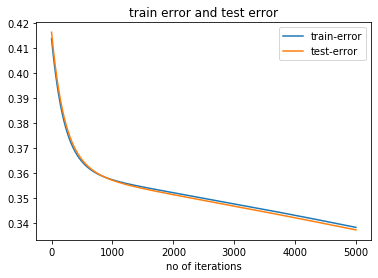

In [67]:
model.convergence_curve()

CONFUSION MATRIX:


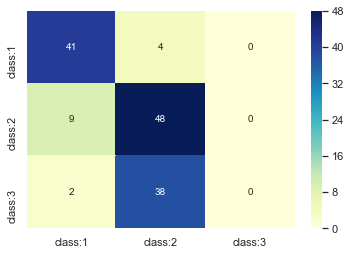

In [97]:
conf_mat(model,wine_train,y_train)

## Looks like class:1 and class:2 are doing relaitvely well but class:3 is completely miscalssified as 1 or 2

OPTIMIZER USED: SGD 

DECAY TYPE: const 

The number of iterations required for convergence is: 3975
The Training-loss at final epoch is: 0.3155245461908493
The Testing-loss at final epoch is: 0.34935582624722344


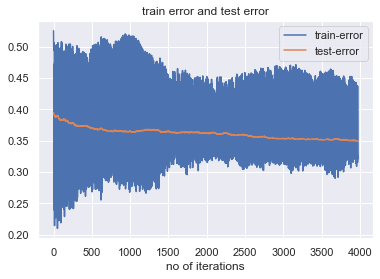

CONFUSION MATRIX:


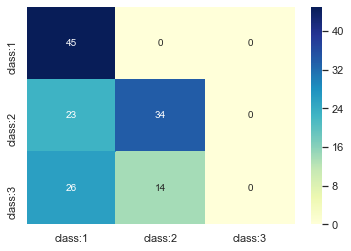

OPTIMIZER USED: SGD 

DECAY TYPE: time-based 

The number of iterations required for convergence is: 3975
The Training-loss at final epoch is: 0.31834324218456633
The Testing-loss at final epoch is: 0.3493255773139624


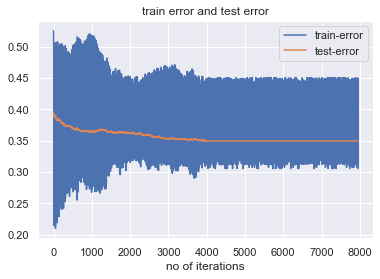

CONFUSION MATRIX:


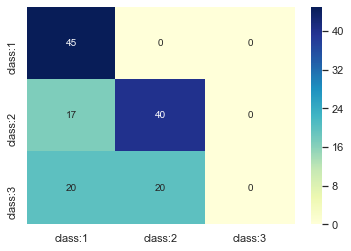

OPTIMIZER USED: SGD 

DECAY TYPE: step-decay 

The number of iterations required for convergence is: 3975
The Training-loss at final epoch is: 0.3238822531241287
The Testing-loss at final epoch is: 0.3493255773139624


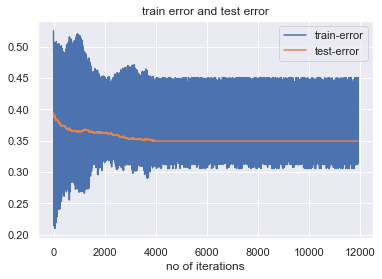

CONFUSION MATRIX:


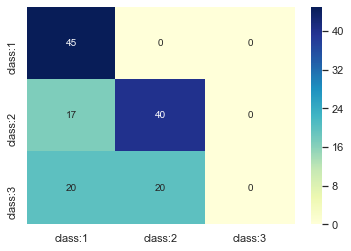

OPTIMIZER USED: SGD 

DECAY TYPE: exponential 

The number of iterations required for convergence is: 3975
The Training-loss at final epoch is: 0.323713133583835
The Testing-loss at final epoch is: 0.3493255773139624


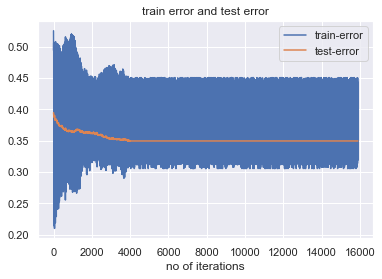

CONFUSION MATRIX:


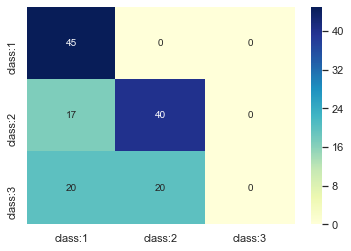

OPTIMIZER USED: MBGD 

DECAY TYPE: const 

The number of iterations required for convergence is: 1634
The Training-loss at final epoch is: 0.35615308472016954
The Testing-loss at final epoch is: 0.35448061837539857


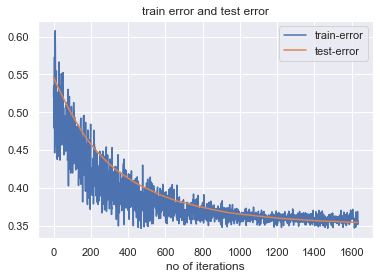

CONFUSION MATRIX:


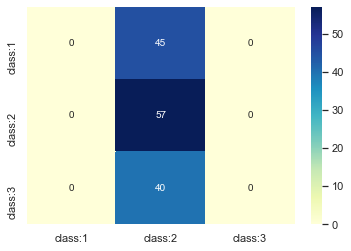

OPTIMIZER USED: MBGD 

DECAY TYPE: time-based 

The number of iterations required for convergence is: 1634
The Training-loss at final epoch is: 0.3648166825892096
The Testing-loss at final epoch is: 0.35432252054475616


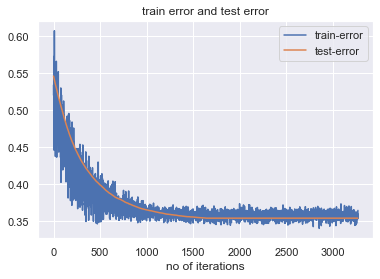

CONFUSION MATRIX:


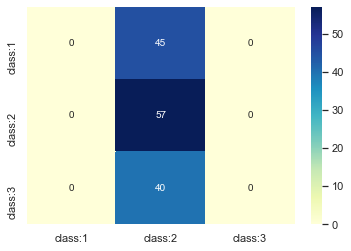

OPTIMIZER USED: MBGD 

DECAY TYPE: step-decay 

The number of iterations required for convergence is: 1634
The Training-loss at final epoch is: 0.35778969513991177
The Testing-loss at final epoch is: 0.35432252054475616


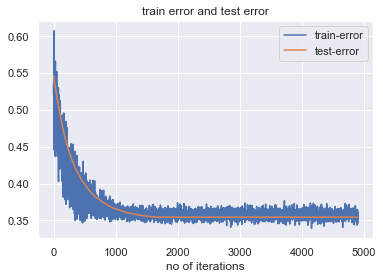

CONFUSION MATRIX:


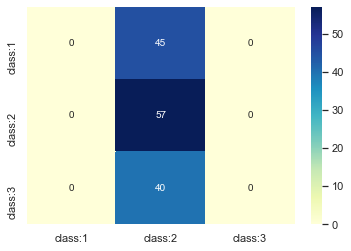

OPTIMIZER USED: MBGD 

DECAY TYPE: exponential 

The number of iterations required for convergence is: 1634
The Training-loss at final epoch is: 0.36416963134514607
The Testing-loss at final epoch is: 0.35432252054475616


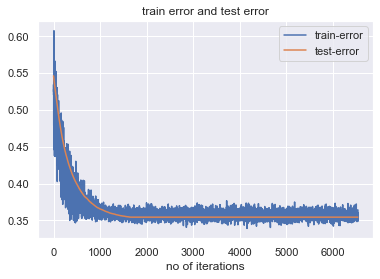

CONFUSION MATRIX:


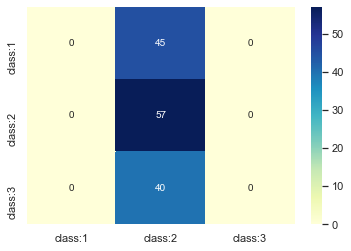

OPTIMIZER USED: SGD with momentum 

BATCH SIZE: 120 

The number of iterations required for convergence is: 1719
The Training-loss at final epoch is: 0.3546320795909743
The Testing-loss at final epoch is: 0.3377971190554398


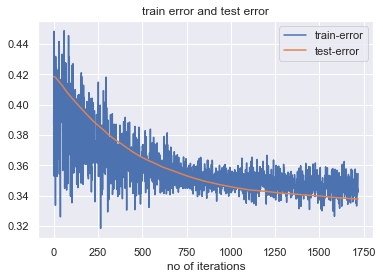

CONFUSION MATRIX:


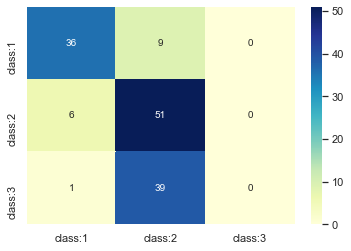

OPTIMIZER USED: Ada Grad 

BATCH SIZE: 120 

The number of iterations required for convergence is: 415
The Training-loss at final epoch is: 0.31764295742949267
The Testing-loss at final epoch is: 0.31033020372678416


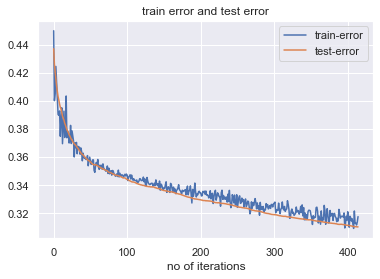

CONFUSION MATRIX:


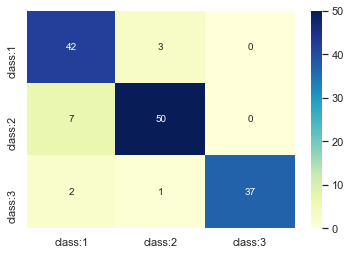

OPTIMIZER USED: RMS prop 

BATCH SIZE: 120 

The number of iterations required for convergence is: 2471
The Training-loss at final epoch is: 0.06556989454354438
The Testing-loss at final epoch is: 0.04191042554333326


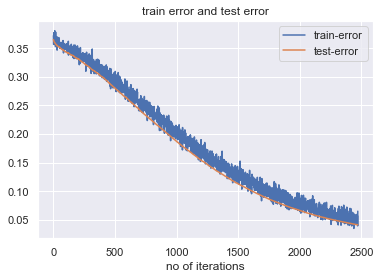

CONFUSION MATRIX:


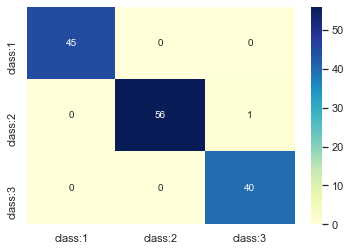

OPTIMIZER USED: Adam 

BATCH SIZE: 120 

The number of iterations required for convergence is: 4674
The Training-loss at final epoch is: 0.0145017042179919
The Testing-loss at final epoch is: 0.017391915068274946


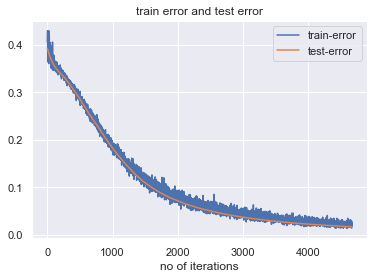

CONFUSION MATRIX:


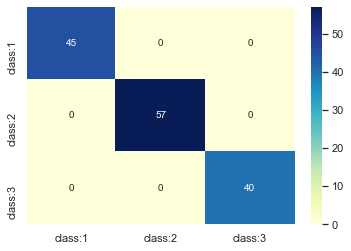

OPTIMIZER USED: AdaMax 

BATCH SIZE: 120 

The number of iterations required for convergence is: 4065
The Training-loss at final epoch is: 0.01812964395223382
The Testing-loss at final epoch is: 0.012466188555471174


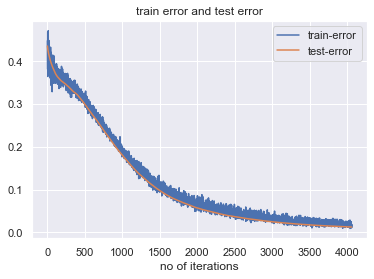

CONFUSION MATRIX:


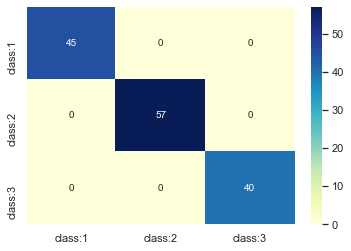

OPTIMIZER USED: Nadam 

BATCH SIZE: 120 

The number of iterations required for convergence is: 2336
The Training-loss at final epoch is: 0.029545462936721945
The Testing-loss at final epoch is: 0.020788783175901035


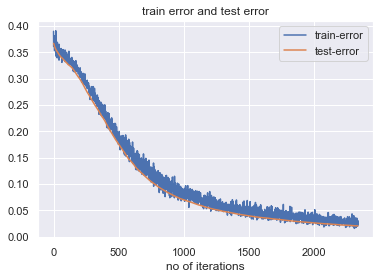

CONFUSION MATRIX:


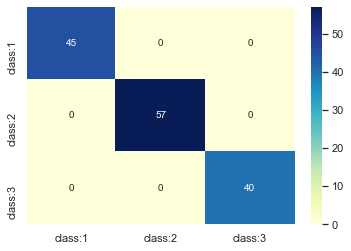

In [103]:
optimizers = ['SGD','MBGD','SGD with momentum','Ada Grad','RMS prop','Adam','AdaMax','Nadam']
decays =['const','time-based','step-decay','exponential']
for opti in optimizers : 
    W1 = np.random.rand(5,13)
    W2 = np.random.rand(3,5)
    b1 = np.random.rand(5)
    b2 = np.random.rand(3)
    model=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=6000,epsilon=1e-7)
    if(opti == 'MBGD' or opti == 'SGD'):
        for decay in decays:
            W1 = np.random.rand(5,13)
            W2 = np.random.rand(3,5)
            b1 = np.random.rand(5)
            b2 = np.random.rand(3)
            print("OPTIMIZER USED:",opti,"\n")
            print("DECAY TYPE:", decay,"\n")
            model.Train_Test_compare(wine_train,y_train,wine_test,y_test,optimisation_method=opti,decay = decay,batch_size =120)
            model.convergence_curve()
            plt.show()
            conf_mat(model,wine_train,y_train)
            plt.show()
    else:
        print("OPTIMIZER USED:",opti,"\n")
        print('BATCH SIZE:',120,"\n")
        model.Train_Test_compare(wine_train,y_train,wine_test,y_test,optimisation_method=opti,batch_size =120)
        model.convergence_curve()
        plt.show()
        conf_mat(model,wine_train,y_train)
        plt.show()
    

# CONCLUSIONS DRAWN : 
- The optimization methods like AdaGrad,RMS prop,Adam,AdaMax and Nadam gave promosing results
- AdaGrad converged in the least number of iterations
- We could also try playing around with the beta parameters(smoothing params),try regularising to avoid ovdrfitting 
- In this case we already had enough features,but if the instances are much larger than the number of attributes,we coulld try increasing the number of neurons  in the hidden-layer or even increase the number of layers
